In [1]:
# import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.gridspec import GridSpec
from plotly.subplots import make_subplots
import seaborn as sns
from geopy import distance

In [2]:
df_train = pd.read_csv("../split/train.csv")

In [3]:
df_train.shape

(1000000, 10)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1000000 non-null  object 
 1   vendor_id           1000000 non-null  int64  
 2   pickup_datetime     1000000 non-null  object 
 3   passenger_count     1000000 non-null  int64  
 4   pickup_longitude    1000000 non-null  float64
 5   pickup_latitude     1000000 non-null  float64
 6   dropoff_longitude   1000000 non-null  float64
 7   dropoff_latitude    1000000 non-null  float64
 8   store_and_fwd_flag  1000000 non-null  object 
 9   trip_duration       1000000 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 76.3+ MB


## We have 10 feathers and 1 target let's go through each attribute briefly:

- id: A unique identifier for each trip. It serves as a primary key to distinguish one trip from another.

- vendor_id: A code indicating the provider associated with the trip record. This could represent different taxi companies or service providers.

- pickup_datetime: The date and time when the meter was engaged, marking the start of the trip.

- passenger_count: The number of passengers in the vehicle. It is a driver-entered value, indicating how many individuals were in the taxi during the trip.

- pickup_longitude: The longitude coordinate where the meter was engaged, i.e., the pickup location.

- dropoff_longitude: The longitude coordinate where the meter was disengaged, i.e., the dropoff location.

- dropoff_latitude: The latitude coordinate where the meter was disengaged, i.e., the dropoff location.

- store_and_fwd_flag: This flag indicates whether the data was sent to the vendor in real-time ("N") or whether it was stored in the vehicle's memory and sent later when a connection was available ("Y").

- trip_duration: The duration of the trip in seconds, i.e., the time between the pickup and dropoff.
**Note : trip_duration is our target Variable.**

In [5]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
vendor_id,1000000.0,1.534793,0.498788,1.000000,1.000000,2.000000,2.000000,2.000000e+00
passenger_count,1000000.0,1.665353,1.315723,0.000000,1.000000,1.000000,2.000000,7.000000e+00
pickup_longitude,1000000.0,-73.973475,0.065404,-121.933342,-73.991852,-73.981728,-73.967346,-6.133553e+01
pickup_latitude,1000000.0,40.750947,0.033745,34.359695,40.737372,40.754131,40.768379,5.188108e+01
dropoff_longitude,1000000.0,-73.973421,0.065432,-121.933304,-73.991341,-73.979767,-73.963036,-6.133553e+01
dropoff_latitude,1000000.0,40.751829,0.035782,34.359695,40.735928,40.754551,40.769833,4.392103e+01
trip_duration,1000000.0,954.884971,3882.070116,1.000000,397.000000,662.000000,1074.000000,2.227612e+06


#### 1. `vendor_id`
- Only two possible values: **1 or 2** (categorical).
- Distribution is slightly skewed toward vendor **2** (mean ≈ 1.54).
- Should be treated as a **categorical feature**, not numeric.

#### 2. `passenger_count`
- Range: **0 to 7**.
- Typical trips: **1–2 passengers** (median = 1, 75% quantile = 2).
- **Potential issues:**
  - `0` passengers → invalid trips.
  - High values (6–7) are rare and could be anomalies.

#### 3. `pickup_longitude` & `pickup_latitude`
- Central location: around **(-74, 40.75)** → matches **NYC coordinates**.
- Extreme values:
  - Longitude min = **-121.93**, Latitude max = **51.88** → far outside NYC.
- **Most values are tightly clustered around NYC**, but outliers exist and need filtering.

#### 4. `dropoff_longitude` & `dropoff_latitude`
- Similar distribution to pickup points.
- Central cluster: **NYC region**.
- Extreme outliers outside valid NYC bounds.
- Filtering required to keep only realistic trips.

#### 5. `trip_duration`
- Mean = **955 seconds (~16 minutes)**.
- Median = **662 seconds (~11 minutes)**.
- Distribution is **right-skewed** (long trips pull the mean up).
- Extreme values:
  - Min = **1 second** → unrealistic.
  - Max = **2,227,612 seconds (~25 days)** → unrealistic (outlier).

---

## Outlier analysis

In [6]:
df_train.select_dtypes(include=[np.number]).skew()

vendor_id             -0.139510
passenger_count        2.125937
pickup_longitude    -383.018403
pickup_latitude       16.821486
dropoff_longitude   -386.828587
dropoff_latitude     -13.633751
trip_duration        202.555754
dtype: float64

## Log transformation for trip duration

In [7]:
df_train['log_trip_duration'] = np.log1p(df_train.trip_duration)


df_train.drop(columns='trip_duration',inplace=True)

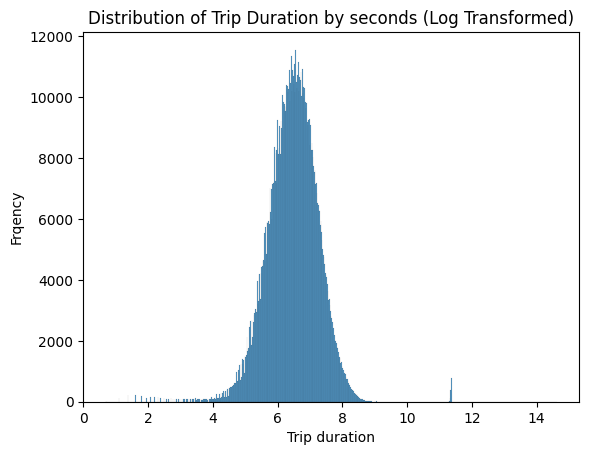

In [8]:
fig = sns.histplot(df_train['log_trip_duration'] ,label = "Trip duration")
plt.title('Distribution of Trip Duration by seconds (Log Transformed)')
plt.xlabel('Trip duration')
plt.ylabel('Frqency')
plt.show()

- The histogram shows the **log-transformed trip duration** in seconds.
- After transformation, the distribution is **much closer to normal (bell-shaped)** compared to the raw `trip_duration`.

---

## Changing Pickup_datetime from object to datetime

**To be able to extract features from it**

In [9]:
df_train["pickup_datetime"] = pd.to_datetime(df_train["pickup_datetime"]) 

## Change Passenger count from int to object as it contain discrete values

In [10]:
df_train['passenger_count'].unique()

array([1, 5, 2, 4, 3, 6, 0, 7])

In [11]:
df_train['passenger_count'] = df_train['passenger_count'].astype('object')

## Remove useless features such as id

In [12]:
df_train.drop(columns=['id'], inplace=True)

## Saving numerical and categorical and date features columns names

In [13]:
numerical_features = df_train.select_dtypes(exclude=['object','datetime64[ns]']).columns
categorical_features = df_train.select_dtypes(include=['object']).columns
date_features = df_train.select_dtypes(include=['datetime64[ns]']).columns

In [14]:
for category in categorical_features:
    print(f"Category: {category}-------------------------")
    print(df_train[category].unique())

Category: passenger_count-------------------------
[1 5 2 4 3 6 0 7]
Category: store_and_fwd_flag-------------------------
['N' 'Y']


## We take numerical and categorical features and analyze the highly correlated features with our target feature (Trip duration).

**Lets start with numerical features**

We'll have a look at the correlation between all the features with the help of Heatmap.

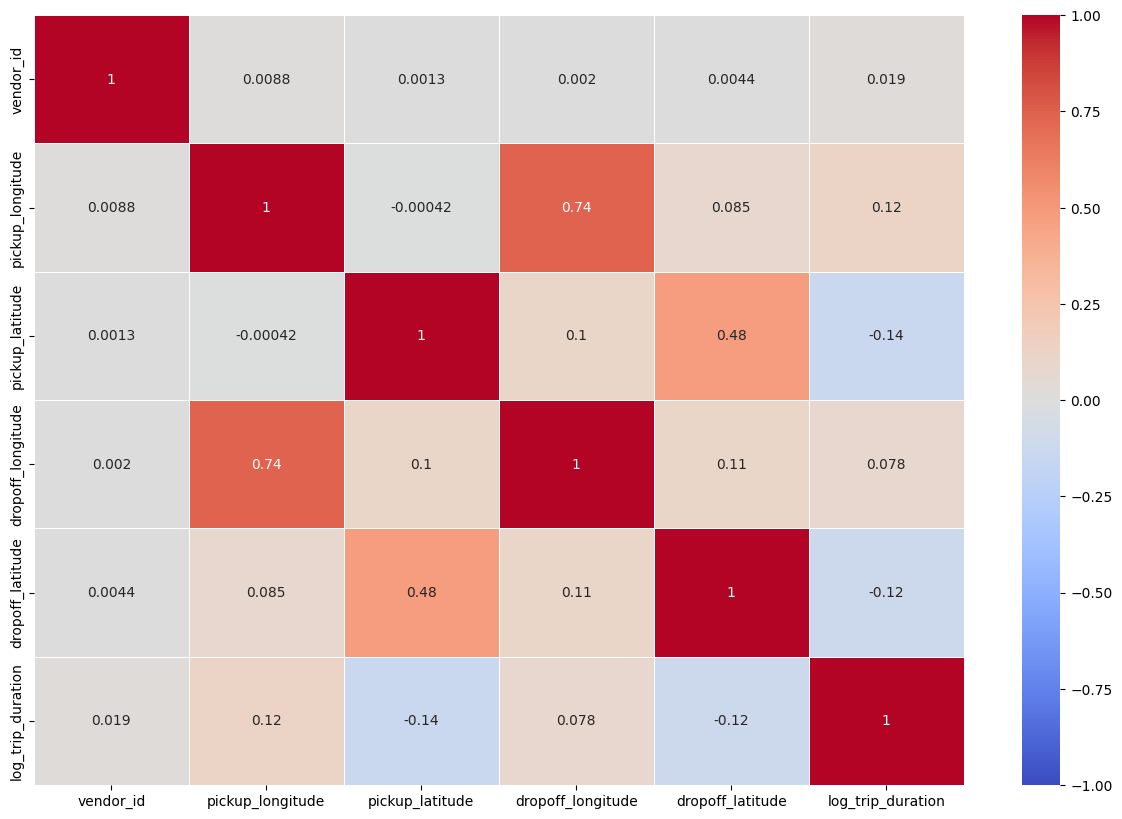

In [15]:
df_corr = df_train[numerical_features]
corr = df_corr.corr()

fig = plt.figure(figsize=(15,10))

sns.heatmap(corr,annot=True,linewidths=.5,cmap='coolwarm',vmin=-1,vmax=1,center=0);

**Clearly there is bad correlation between numerical features and trip duration so lets add new feature such as distance**

In [16]:
def haversine_distance(df):
    pick = (df['pickup_latitude'], df['pickup_longitude'])
    drop = (df['dropoff_latitude'], df['dropoff_longitude'])
    dist = distance.geodesic(pick, drop).km
    return dist

df_train['distance'] = df_train.apply(haversine_distance, axis=1)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_9400\2588515649.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df_train, x='distance', palette='magma', ax=ax)


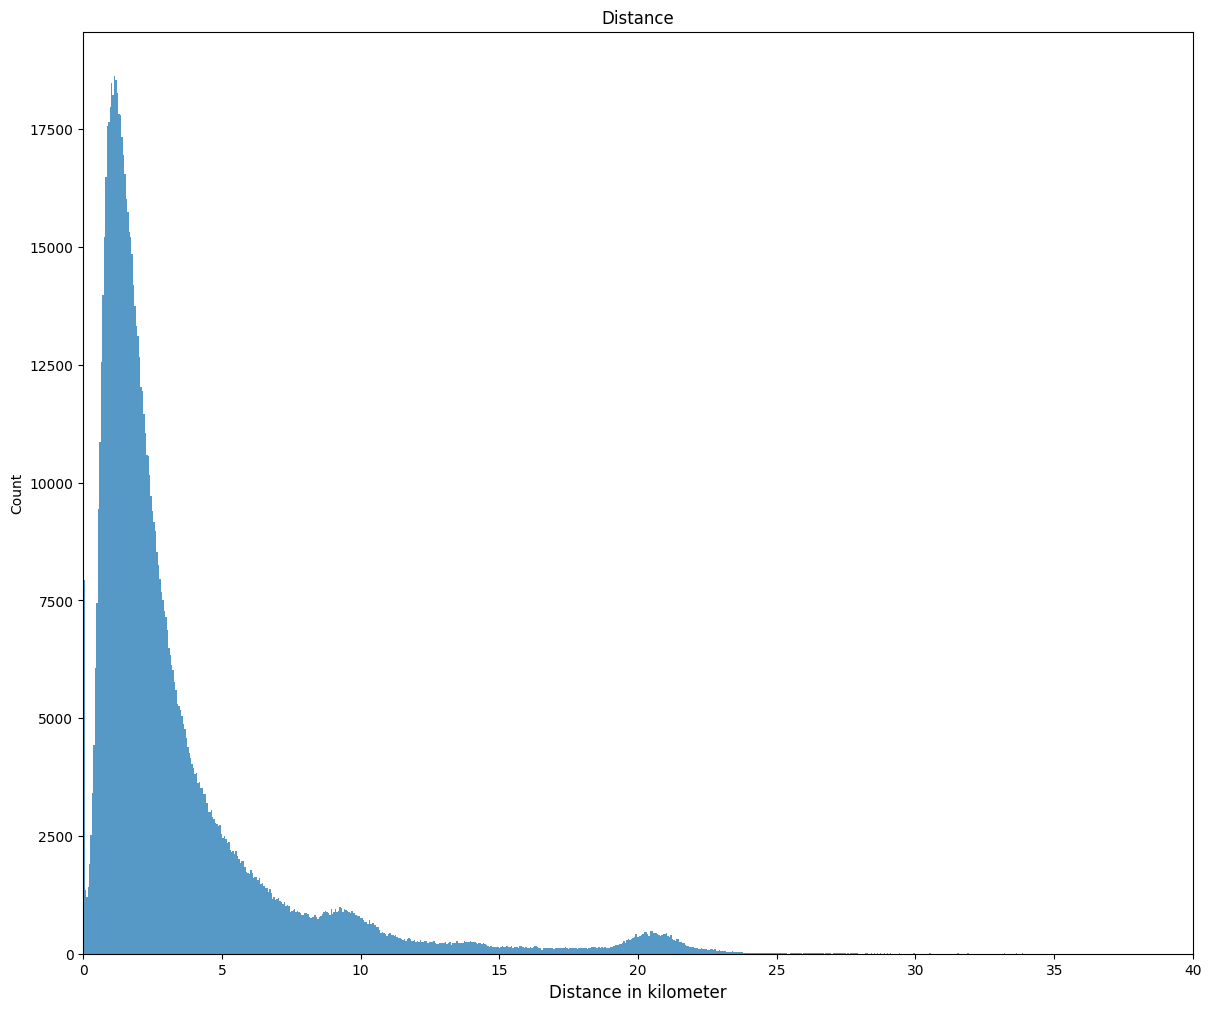

In [17]:
fig = plt.figure(constrained_layout=True, figsize=(12, 10))
gs = fig.add_gridspec(1, 1)  
ax = fig.add_subplot(gs[0, 0])  # Add a single subplot

sns.histplot(data=df_train, x='distance', palette='magma', ax=ax)
ax.set_title('Distance')
ax.set_xlabel('Distance in kilometer', fontsize=12)
plt.xlim(0, 40)
plt.show()


- Looks like most of trip goes from less then 1 kilo meter to 25 kilometer
- The shape of histogram right skewed (we can use a log transformation to make it more normal distributed to help our linear model).

In [18]:
df_train['distance'] = np.log1p(df_train.distance)

log_trip_duration = df_train.pop('log_trip_duration')
df_train['log_trip_duration'] = log_trip_duration

#Update the numerical features
numerical_features = df_train.select_dtypes(exclude=['object','datetime']).columns

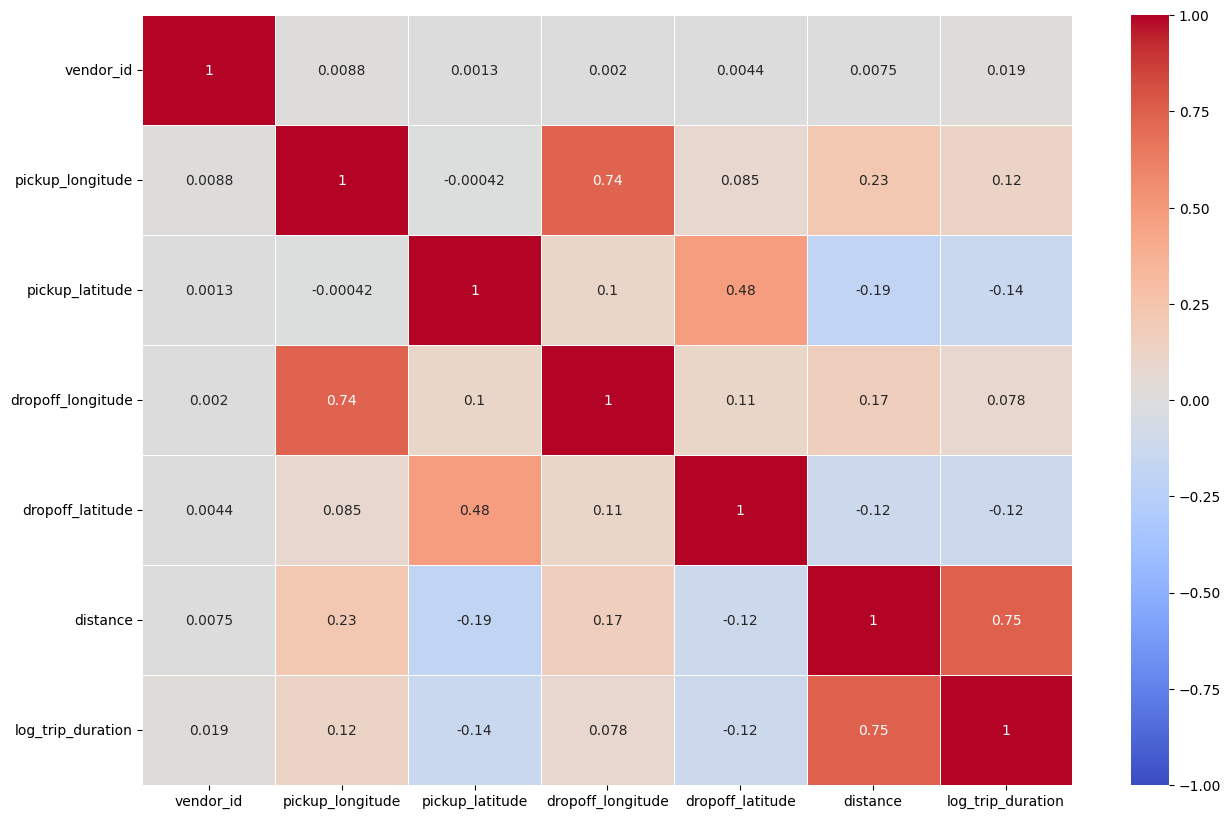

In [19]:
df_corr = df_train[numerical_features]
corr = df_corr.corr()

fig = plt.figure(figsize=(15,10))

sns.heatmap(corr,annot=True,linewidths=.5,cmap='coolwarm',vmin=-1,vmax=1,center=0);

## Categorical Analysis

C:\Users\Administrator\AppData\Local\Temp\ipykernel_9400\1670681235.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_train, x="vendor_id", y= df_train['log_trip_duration'], palette='hot', ax=ax1)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_9400\1670681235.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_train, x=df_train["passenger_count"], y= df_train['log_trip_duration'], palette='magma', ax=ax2)


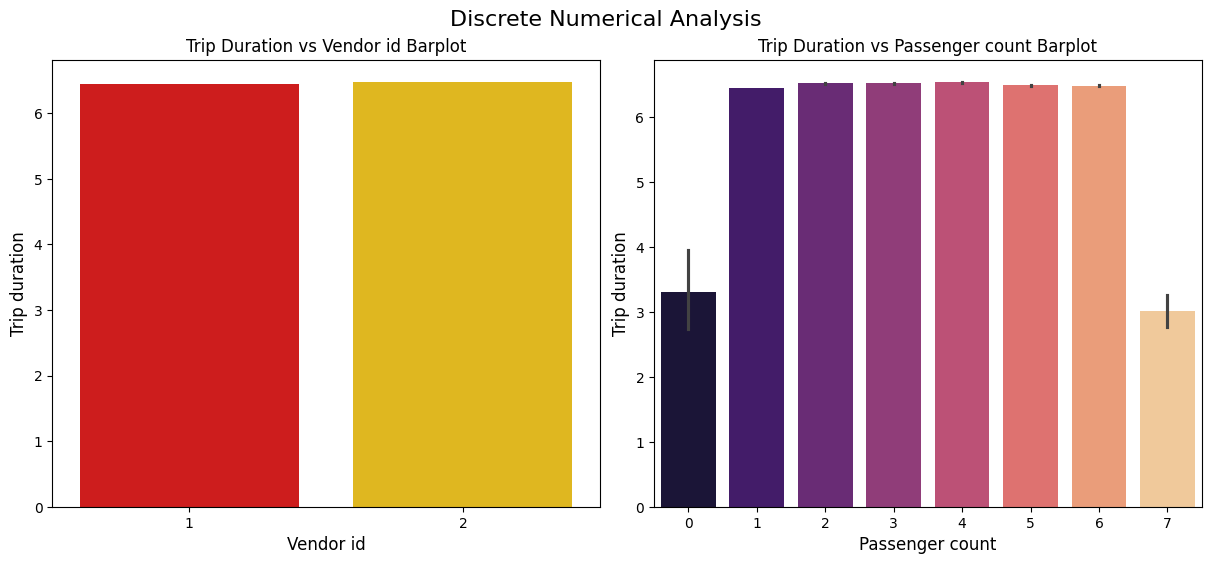

In [20]:
fig = plt.figure(constrained_layout=True, figsize=(12, 10))
gs = GridSpec(2, 2, figure=fig)

# Subplot 1: Bar Plot for vendor_id
ax1 = fig.add_subplot(gs[0, 0])
sns.barplot(data=df_train, x="vendor_id", y= df_train['log_trip_duration'], palette='hot', ax=ax1)
ax1.set_title('Trip Duration vs Vendor id Barplot')
ax1.set_xlabel("Vendor id", fontsize=12)
ax1.set_ylabel("Trip duration", fontsize=12)

# Subplot 2: Bar Plot for passenger_count
ax2 = fig.add_subplot(gs[0, 1])
sns.barplot(data=df_train, x=df_train["passenger_count"], y= df_train['log_trip_duration'], palette='magma', ax=ax2)
ax2.set_title('Trip Duration vs Passenger count Barplot')
ax2.set_xlabel("Passenger count", fontsize=12)
ax2.set_ylabel("Trip duration", fontsize=12)

# Add a title for the entire figure
fig.suptitle("Discrete Numerical Analysis", fontsize=16)

# Show the plots
plt.show()

- Trip duration and Vendor ID: It's difficult to discern any clear patterns or trends between trip duration and vendor ID from the bar chart. The bars appear to be spread out relatively evenly across the x-axis, suggesting no significant difference in trip duration among vendors.

- When the number of passenger groups from [1 to 6] take constant trip duration and the number of passenger groups from [7 to 8] take less trip duration.

- Possible explanations:

- Vehicle Capacity : It's possible that the vehicles used by both vendors have a maximum capacity of 6 passengers. When there are 6 or fewer passengers, the vehicles are operating at their maximum capacity, and the trip duration remains constant because the vehicles are fully utilized.

- **If vendor of the taxi not effect with trip duration so idea of vehicle capacity not correct** so we need to use a boxplot to detect If we just dealing with some random noise or passengers groups from [7 to 8] just travel less than another groups.

C:\Users\Administrator\AppData\Local\Temp\ipykernel_9400\53323853.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train, x="vendor_id", y= df_train['log_trip_duration'], palette='hot', ax=ax1)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_9400\53323853.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train, x="passenger_count", y= df_train['log_trip_duration'], palette='magma', ax=ax2)


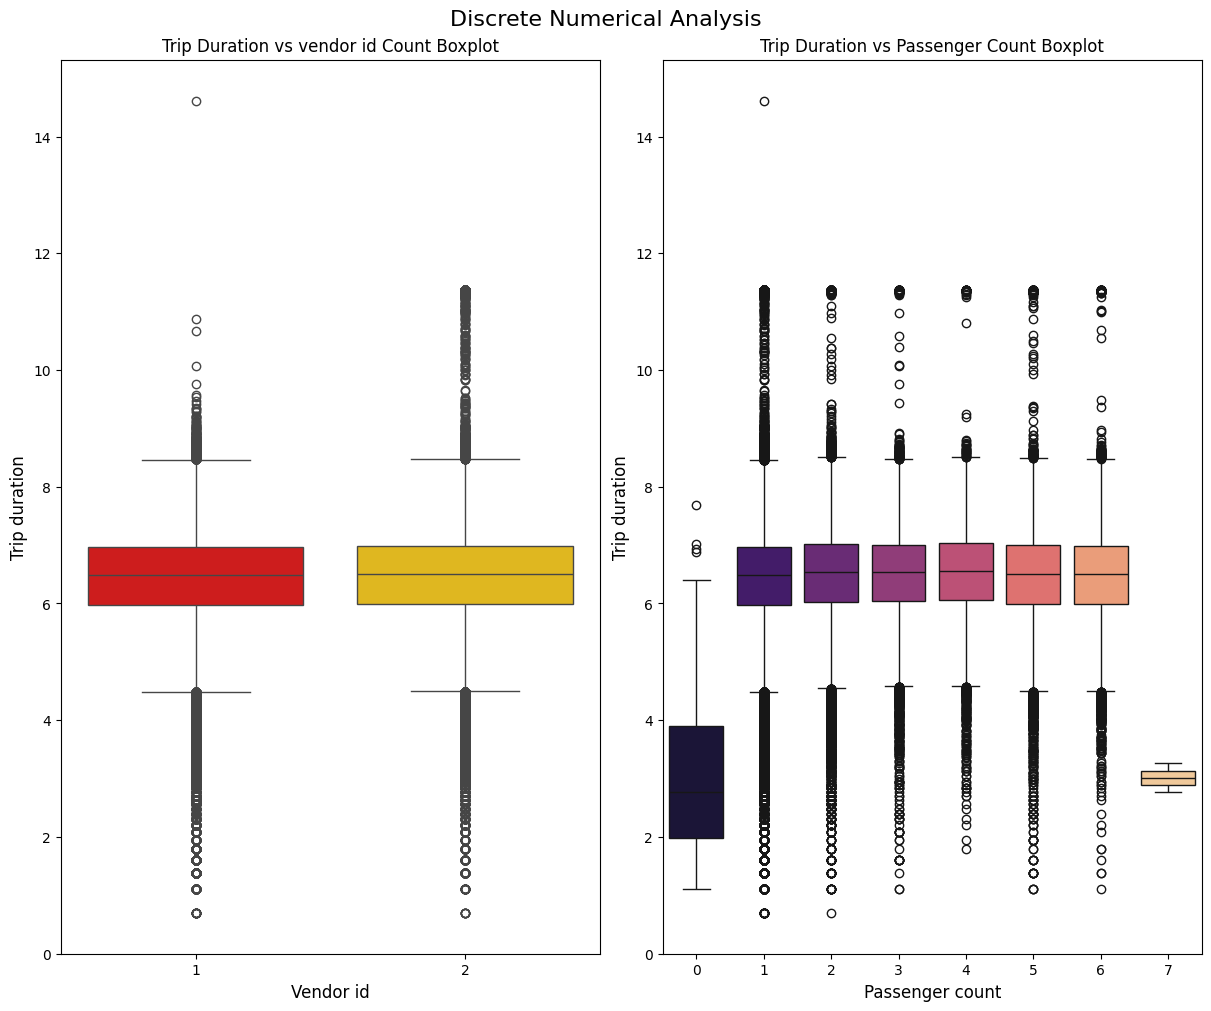

In [21]:
fig = plt.figure(constrained_layout=True, figsize=(12, 10))
gs = GridSpec(1, 2, figure=fig)

# Subplot 1: Box Plot for vendor_id
ax1 = fig.add_subplot(gs[0, 0])
sns.boxplot(data=df_train, x="vendor_id", y= df_train['log_trip_duration'], palette='hot', ax=ax1)
ax1.set_title("Trip Duration vs vendor id Count Boxplot")
ax1.set_xlabel("Vendor id", fontsize=12)
ax1.set_ylabel("Trip duration", fontsize=12)

# Subplot 2: Box Plot for passenger_count
ax2 = fig.add_subplot(gs[0, 1])
sns.boxplot(data=df_train, x="passenger_count", y= df_train['log_trip_duration'], palette='magma', ax=ax2)
ax2.set_title("Trip Duration vs Passenger Count Boxplot")
ax2.set_xlabel("Passenger count", fontsize=12)
ax2.set_ylabel("Trip duration", fontsize=12)

# Add a title for the entire figure
fig.suptitle("Discrete Numerical Analysis", fontsize=16)

# Show the plots
plt.show()

- Trip duration distribution: The distribution of trip durations appears to be positively skewed for both groups, meaning there are more shorter trips than longer trips. This is especially evident for the group with lower passenger counts (left boxplot).

- Median trip duration: The median trip duration, represented by the horizontal line within the box, is longer for the group with higher passenger counts (right boxplot). This suggests that trips with more passengers tend to take longer overall.

- Outliers: There are a few outliers for both groups, represented by the circles beyond the whiskers. These are individual trips that were much longer than the majority of trips in their respective groups and this Support conclusion passengers groups from [7 to 8] just travel less than another groups because Trip purpose.

## Datetime features

In [22]:
bins = [0, 2, 5, 8, 11, 12]  # 0, 2, 5, 8, 11, 12 represent the starting and ending months of each season
labels = ['0', '1', '2', '3', '4'] # Labels for each season ['Winter', 'Spring', 'Summer', 'Autumn', 'Winter'] 

df_train["hour"] = df_train["pickup_datetime"].dt.hour
df_train["day"]  = df_train["pickup_datetime"].dt.day
df_train["dayofweek"] = df_train["pickup_datetime"].dt.dayofweek
df_train["month"]  = df_train["pickup_datetime"].dt.month
df_train['Season'] = pd.cut(df_train["month"] , bins=bins, labels=labels, right=False,ordered=False)

datetime_features = ['month', 'dayofweek', 'day','hour', 'Season']


def get_time_period(hour):
    if 5 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 18:
        return "Afternoon"
    else:
        return "Night"
    
df_time_period = pd.DataFrame()
df_time_period["time_period"] = df_train["hour"].apply(get_time_period)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_9400\3279822458.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_train, x="Season", y='log_trip_duration', palette='hot', ax=ax1)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_9400\3279822458.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_time_period, x="time_period",  y=df_train['log_trip_duration'], palette='magma', ax=ax2)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_9400\3279822458.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_train, 

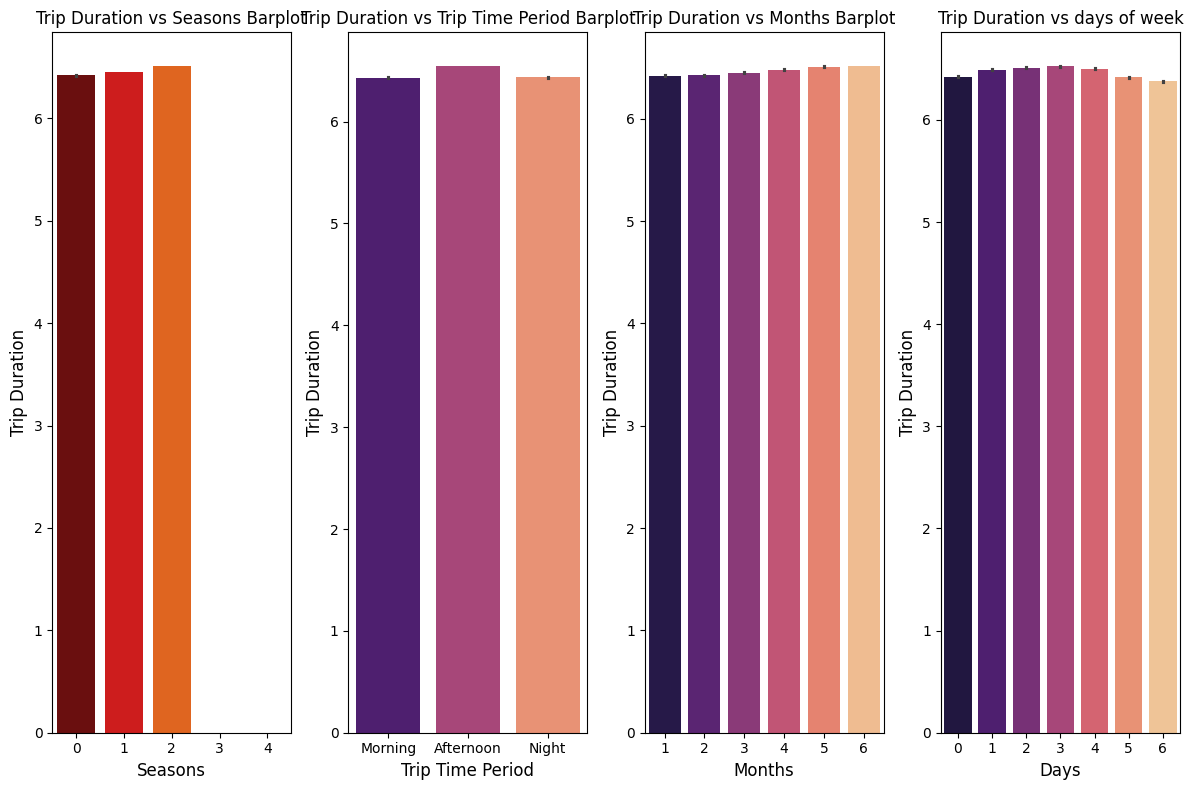

In [23]:
# Create the figure with GridSpec and specify the size
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 8))

# Subplot 1: Bar Plot for Seasons
sns.barplot(data=df_train, x="Season", y='log_trip_duration', palette='hot', ax=ax1)
ax1.set_title('Trip Duration vs Seasons Barplot')
ax1.set_xlabel("Seasons", fontsize=12)
ax1.set_ylabel("Trip Duration", fontsize=12)

# Subplot 2: Bar Plot for time period
sns.barplot(data=df_time_period, x="time_period",  y=df_train['log_trip_duration'], palette='magma', ax=ax2)
ax2.set_title('Trip Duration vs Trip Time Period Barplot')
ax2.set_xlabel("Trip Time Period", fontsize=12)
ax2.set_ylabel("Trip Duration", fontsize=12)

# Subplot 3: Bar Plot for months
sns.barplot(data=df_train, x="month", y='log_trip_duration', palette='magma', ax=ax3)
ax3.set_title('Trip Duration vs Months Barplot')
ax3.set_xlabel("Months", fontsize=12)
ax3.set_ylabel("Trip Duration", fontsize=12)

# Subplot 3: Bar Plot for months
sns.barplot(data=df_train, x="dayofweek", y='log_trip_duration', palette='magma', ax=ax4)
ax4.set_title('Trip Duration vs days of week')
ax4.set_xlabel("Days", fontsize=12)
ax4.set_ylabel("Trip Duration", fontsize=12)

# Adjust layout for better appearance
plt.tight_layout()

# Show the plots
plt.show()

- The longer trip durations during summer might be attributed to vacations and holidays, which lead to increased traffic on the roads.
- Longer trip durations in the afternoon can be explained by higher levels of crowding during that time of day.
- April, May, and July experience longer trip durations compared to other months.

In [24]:
df_train.shape

(1000000, 15)

In [25]:
df_train.head()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,distance,log_trip_duration,hour,day,dayofweek,month,Season
0,2,2016-06-08 07:36:19,1,-73.985611,40.735943,-73.980331,40.760468,N,1.324340,6.947937,7,8,2,6,2
1,2,2016-04-03 12:58:11,1,-73.978394,40.764351,-73.991623,40.749859,N,1.084872,6.719013,12,3,6,4,1
2,2,2016-06-05 02:49:13,5,-73.989059,40.744389,-73.973381,40.748692,N,0.878683,6.421622,2,5,6,6,2
3,2,2016-05-05 17:18:27,2,-73.990326,40.731136,-73.991264,40.748917,N,1.090605,6.766192,17,5,3,5,2
4,1,2016-05-12 17:43:38,4,-73.789497,40.646675,-73.987137,40.759232,N,3.084741,8.510773,17,12,3,5,2
